<a href="https://colab.research.google.com/github/musicjae/intro_to_python/blob/master/Pytorch/practice_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# argparse

In [ ]:
import argparse

parser = argparse.ArgumentParser()
args = parser.parse_args("")

In [ ]:
args.num_layer = 5
args.in_dim=100
print(args.num_layer)
print(args)

5
Namespace(in_dim=100, num_layer=5)


In [ ]:
linears=[]
for i in range(args.num_layer):
    linears.append(i)

print(linears)

d = vars(args)
print(d)

[0, 1, 2, 3, 4]
{'num_layer': 5, 'in_dim': 100}


# RNN

(10, 2390, 1)


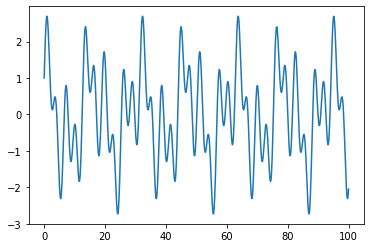

In [110]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn


# ====== Generating Dataset ====== #
num_data = 2400
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t) + np.sin(2*t) + np.cos(0.4*t)
e = np.random.normal(0, 0.1, num_data)
# y = y + e


seq_len = 10
X = []
y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])
    
X = np.array(X)
y_true = np.array(y_true)

X = np.swapaxes(X,0,1)
X = np.expand_dims(X, axis=2)
print(X.shape) # 맨 마지막에 1을 넣어줌으로써, for문에서 X를 처리할 때, x의 shape이 (batch_size, input_layer)로 표현할 수 있다.

plt.plot(t, y)

In [52]:
seq_len = 10
X=[]
true_y=[]
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    true_y.append(y[i+seq_len])

X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)


(2390, 10)
(2400,)


## model RNN

$h_t = f(Ux_t+Wh_{t-1})$. 

$y_t = f(Vh_t)$

In [94]:
class RNN(nn.Module):
    def __init__(self,input_dim,output_dim,hid_dim,batch_size):
        super(RNN,self).__init__()

        self.input_dim = input_dim
        self.hid_dim= hid_dim
        self.output_dim = output_dim
        self.batch_size = batch_size

        self.U = nn.Linear(self.input_dim,self.hid_dim,bias=False)
        self.W = nn.Linear(self.hid_dim,self.hid_dim,bias=False)
        self.V = nn.Linear(self.hid_dim,self.output_dim,bias=False)

        self.activation = nn.Tanh()

        self.hidden = self.init_hidden()# hidden state init

    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        return torch.zeros(self.batch_size,self.hid_dim)#batch_size = 1

    def forward(self, x):
        #print(self.hidden[0])
        h = self.activation(self.U(x) + self.W(self.hidden))
        y = self.V(h)

        return y, h



X (10,2390,1) 을 for 문에 넣어, 각각의 iter 마다 예측을 한다. 따라서 prediction_y  는 10 개이다.

In [95]:
model = RNN(1,1,10,2390) # input,output,hid_dim,batch_size

# ==== Train === #

for x in X:
    x = torch.Tensor(x).float()
    y, hs = model(x)
    model.hidden = hs

print(y.shape,hs.shape)  # hs가 잘 업데이트 하는 것을 확인


torch.Size([2390, 1]) torch.Size([2390, 10])


## train

epoch:0 	 loss:0.9619717597961426
epoch:1 	 loss:0.9523297548294067
epoch:2 	 loss:0.9427917003631592
epoch:3 	 loss:0.9333564639091492
epoch:4 	 loss:0.924022912979126
epoch:5 	 loss:0.9147897958755493
epoch:6 	 loss:0.9056562185287476
epoch:7 	 loss:0.8966208696365356
epoch:8 	 loss:0.8876828551292419
epoch:9 	 loss:0.8788408637046814
epoch:10 	 loss:0.8700941205024719
epoch:11 	 loss:0.8614416122436523
epoch:12 	 loss:0.8528822064399719
epoch:13 	 loss:0.8444147706031799
epoch:14 	 loss:0.8360385298728943
epoch:15 	 loss:0.8277525305747986
epoch:16 	 loss:0.8195556998252869
epoch:17 	 loss:0.8114471435546875
epoch:18 	 loss:0.8034259080886841
epoch:19 	 loss:0.7954911589622498
epoch:20 	 loss:0.7876418232917786
epoch:21 	 loss:0.7798771858215332
epoch:22 	 loss:0.7721962928771973
epoch:23 	 loss:0.7645982503890991
epoch:24 	 loss:0.7570821642875671
epoch:25 	 loss:0.7496472001075745
epoch:26 	 loss:0.742292582988739
epoch:27 	 loss:0.7350174784660339
epoch:28 	 loss:0.72782099246978

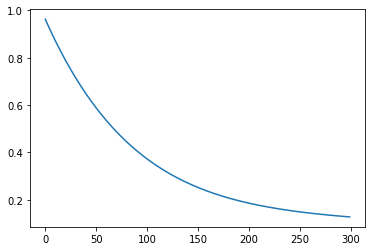

In [113]:
model = RNN(1,1,10,2390) # input,output,hid_dim,batch_size
optimizer = optim.SGD(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs= 300
# ==== Train === #

losses=[]

for epoch in range(epochs):

    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    model.hidden = model.init_hidden() # Recurrent Model 사용 시에는, 이렇게 히든 값을 초기화할 수 있게 하라 at every iter

    for x in X:
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()
        y_pred, hs = model(x)
        model.hidden = hs

    loss = loss_fn(y_pred.view(-1),y_true.view(-1))
    loss.backward()
    optimizer.step()
    
    print(f'epoch:{epoch} \t loss:{loss.item()}')
    losses.append(loss.item())

plt.plot(losses)
plt.show()

## val

In [98]:
X.shape
np.expand_dims(X[:,0,:],1).shape

(10, 1, 1)

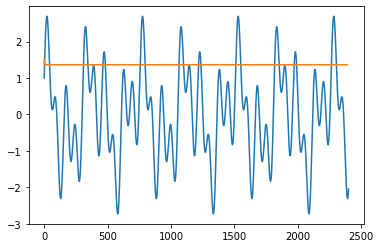

In [115]:
losses=[]
test_X = np.expand_dims(X[:,0,:],1)
list_ypred=[]

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size = 1)

    for x in test_X:
        x = torch.Tensor(x).float()   
        y_pred, hs = model(x)
        model.hidden = hs
    #print(y_pred[0].view(-1).item())
    
    list_ypred.append(y_pred[0].view(-1).item())
    for i in range(2389):
        y_pred, hs = model(y_pred)
        list_ypred.append(y_pred[0].view(-1).item())

plt.plot(y)
plt.plot(list_ypred)



